In [32]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt


In [33]:
data_sets_path = "./data/dog&cat"
BATCH = 8


In [34]:
vgg_conv = vgg16.VGG16(weights='imagenet',
                       include_top=True,
                       input_shape=(224, 224, 3))
vgg_conv = Sequential(vgg_conv.layers[:-1],"vgg16_Extraction")
vgg_conv.build(vgg_conv.input_shape)

In [35]:
train_data_sets = image_dataset_from_directory(data_sets_path, label_mode="int",
                                               class_names=None,
                                               color_mode="rgb",
                                               batch_size=32,
                                               image_size=(224, 224),
                                               shuffle=True,
                                               seed=123,
                                               validation_split=0.2,
                                               subset="training",
                                               interpolation="bilinear",
                                               follow_links=False,
                                               )
test_data_sets = image_dataset_from_directory(data_sets_path, label_mode="int",
                                              class_names=None,
                                              color_mode="rgb",
                                              batch_size=32,
                                              image_size=(224, 224),
                                              shuffle=True,
                                              seed=123,
                                              validation_split=0.2,
                                              subset="validation",
                                              interpolation="bilinear",
                                              follow_links=False,
                                              )
print(train_data_sets.class_names)
print(train_data_sets)


Found 195 files belonging to 2 classes.
Using 156 files for training.
Found 195 files belonging to 2 classes.
Using 39 files for validation.
['buddydog', 'pussycat']
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


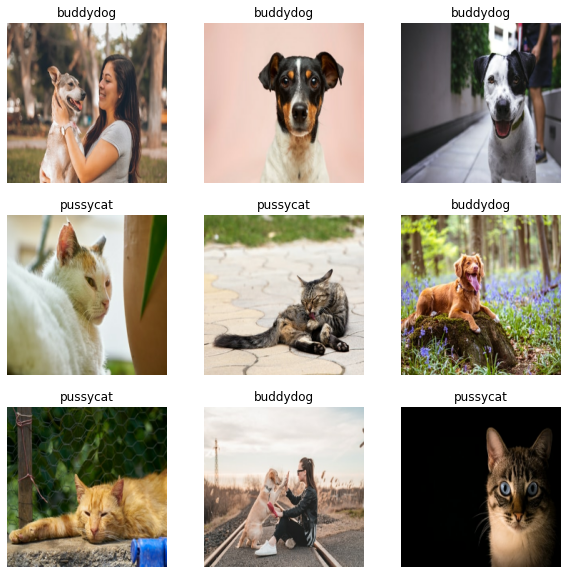

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_data_sets.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data_sets.class_names[labels[i]])
    plt.axis("off")

In [37]:
from tensorflow.keras.layers import Rescaling
normalizer = Rescaling(1./255)
def normalization_layer(data_sets) :
    return data_sets.map(lambda x, y: (normalizer(x), y))

In [38]:

import numpy as np
train_normalization_layer = normalization_layer(train_data_sets)
test_normalization_layer = normalization_layer(test_data_sets)
image_batch, labels_batch = next(iter(train_normalization_layer))
first_image = image_batch[1]
print(np.min(first_image), np.max(first_image))

0.0 0.9995311


In [39]:
from sklearn import svm
svm_model = svm.SVC(kernel="linear")

In [40]:
image_batch, labels_batch = next(iter(train_data_sets))
batch_predict = vgg_conv.predict(image_batch)
print(image_batch.shape)
print(batch_predict.shape)
print(labels_batch.shape)

(32, 224, 224, 3)
(32, 4096)
(32,)


In [102]:
# train svm
from tqdm import tqdm


def train(dataloader, model):
    for image_batch, labels_batch in tqdm(dataloader):
        batch_predict = vgg_conv.predict(image_batch)
        model.fit(batch_predict, labels_batch)


In [117]:
def printAccuracy(dataloader, model):
    sum = 0
    i = 0
    for image_batch, labels_batch in tqdm(dataloader):
        batch_predict = vgg_conv.predict(image_batch)
        sum = sum + model.score(batch_predict, labels_batch)
        i += 1
    sum = sum/i
    print(f"accuracy: {sum}")


In [118]:
train(train_data_sets,svm_model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [116]:
printAccuracy(test_data_sets, svm_model)


100%|██████████| 2/2 [00:11<00:00,  5.56s/it]

accuracy: 0.0


In [106]:
def predict(image):
    extration = vgg_conv.predict(image)
    return svm_model.predict(extration)


def process_image(image):
    image = np.array(image).astype('float32')/255
    image = np.expand_dims(image, axis=0)
    return image


In [94]:
from PIL import Image


def load_image(path):
    image = Image.open(path)
    image.show()
    image = image.convert(
        'RGB').resize((224, 224), Image.ANTIALIAS)
    image = np.array(image).astype('float32')/255
    image = np.expand_dims(image, axis=0)
    return image


In [98]:
image = load_image("sample2.jpg")
print(image.shape)
# plt.imread(images[0].numpy().astype("uint8"))
print(predict(image))

(1, 224, 224, 3)
[1]
